In [ ]:
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
import torch


dataset = load_dataset("wiki_qa", split="train[:2000]")


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained("gpt2")


def preprocess(example):
    prompt = f"Q: {example['question']} A: {example['answer']}"
    encoding = tokenizer(prompt, truncation=True, padding="max_length", max_length=128)
    encoding["labels"] = encoding["input_ids"].copy()
    return encoding

tokenized_dataset = dataset.map(preprocess)


data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=1,
    logging_steps=100,
    evaluation_strategy="no",
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


ModuleNotFoundError: No module named 'transformers'

In [ ]:
class RewardModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
outputs = model(**inputs)
output_embeddings = outputs.hidden_states[-1].mean(dim=1).detach()

reward_model = RewardModel(input_size=output_embeddings.size(1), hidden_size=64).to(device)

preferred_outputs = output_embeddings[0].unsqueeze(0)
non_preferred_outputs = output_embeddings[1].unsqueeze(0)

reward_optimizer = torch.optim.Adam(reward_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

for epoch in range(100):
    preferred_reward = reward_model(preferred_outputs)
    non_preferred_reward = reward_model(non_preferred_outputs)
    loss = criterion(preferred_reward, torch.tensor([[1.0]], device=device)) + \
           criterion(non_preferred_reward, torch.tensor([[0.0]], device=device))
    loss.backward()
    reward_optimizer.step()
    reward_optimizer.zero_grad()
    print(f"Reward Model Epoch {epoch+1}, Loss: {loss.item()}")

Reward Model Epoch 1, Loss: 7.826125144958496
Reward Model Epoch 2, Loss: 6.546499252319336
Reward Model Epoch 3, Loss: 5.402947425842285
Reward Model Epoch 4, Loss: 4.3972249031066895
Reward Model Epoch 5, Loss: 3.523787021636963
Reward Model Epoch 6, Loss: 2.7738595008850098
Reward Model Epoch 7, Loss: 2.1488659381866455
Reward Model Epoch 8, Loss: 1.640026569366455
Reward Model Epoch 9, Loss: 1.246246576309204
Reward Model Epoch 10, Loss: 0.9509943127632141
Reward Model Epoch 11, Loss: 0.7449208498001099
Reward Model Epoch 12, Loss: 0.6208666563034058
Reward Model Epoch 13, Loss: 0.554884135723114
Reward Model Epoch 14, Loss: 0.5345035791397095
Reward Model Epoch 15, Loss: 0.5476740002632141
Reward Model Epoch 16, Loss: 0.5826603770256042
Reward Model Epoch 17, Loss: 0.6293424963951111
Reward Model Epoch 18, Loss: 0.6765734553337097
Reward Model Epoch 19, Loss: 0.7173990607261658
Reward Model Epoch 20, Loss: 0.7469422817230225
Reward Model Epoch 21, Loss: 0.7615346312522888
Reward M

In [ ]:
class DQN(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
embedding_size = model.config.hidden_size
hidden_size = 256
vocab_size = model.config.vocab_size

dqn = DQN(embedding_size, hidden_size, vocab_size).to(device)
target_dqn = DQN(embedding_size, hidden_size, vocab_size).to(device)
target_dqn.load_state_dict(dqn.state_dict())

learning_rate = 1e-4
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
batch_size = 32
buffer_size = 10000
target_update = 10

replay_buffer = deque(maxlen=buffer_size)

dqn_optimizer = torch.optim.Adam(dqn.parameters(), lr=learning_rate)

num_episodes = 30
epsilon = epsilon_start

for episode in range(num_episodes):
    for prompt_idx, prompt in enumerate(prompts):
        prompt_inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**prompt_inputs)
            state = outputs.hidden_states[-1].mean(dim=1)
        generated_tokens = []
        total_reward = 0
        done = False
        max_length = 50

        for t in range(max_length):
            if random.random() < epsilon:
                action = torch.randint(0, vocab_size, (1,)).to(device)
            else:
                with torch.no_grad():
                    q_values = dqn(state)
                    action = torch.argmax(q_values, dim=1)

            generated_tokens.append(action.item())
            next_input = torch.cat([prompt_inputs.input_ids, torch.tensor([action.item()]).unsqueeze(0).to(device)], dim=1)
            with torch.no_grad():
                next_outputs = model(input_ids=next_input)
                next_state = next_outputs.hidden_states[-1].mean(dim=1)
            with torch.no_grad():
                reward = reward_model(next_state).item()
            done = (action.item() == tokenizer.eos_token_id) or (t == max_length - 1)

            replay_buffer.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            if done:
                break

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        if len(replay_buffer) >= batch_size:
            mini_batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*mini_batch)

            states = torch.cat(states, dim=0)
            actions = torch.tensor(actions, device=device)
            rewards = torch.tensor(rewards, device=device).float()
            next_states = torch.cat(next_states, dim=0)
            dones = torch.tensor(dones, device=device).float()

            current_q = dqn(states).gather(1, actions.unsqueeze(1))

            with torch.no_grad():
                max_next_q = target_dqn(next_states).max(1)[0]
                target_q = rewards + gamma * max_next_q * (1 - dones)

            loss = F.mse_loss(current_q.squeeze(), target_q)

            dqn_optimizer.zero_grad()
            loss.backward()
            dqn_optimizer.step()
        if episode % target_update == 0:
            target_dqn.load_state_dict(dqn.state_dict())

    print(f"Episode {episode+1}, Epsilon: {epsilon:.4f}, Reward: {total_reward:.4f}")

Episode 1, Epsilon: 0.7783, Reward: -59.8907
Episode 2, Epsilon: 0.6058, Reward: -59.2364
Episode 3, Epsilon: 0.4715, Reward: -59.1119
Episode 4, Epsilon: 0.3670, Reward: -59.5634
Episode 5, Epsilon: 0.2856, Reward: -59.5912
Episode 6, Epsilon: 0.2223, Reward: -56.7043
Episode 7, Epsilon: 0.1730, Reward: -57.1036
Episode 8, Epsilon: 0.1347, Reward: -57.7745
Episode 9, Epsilon: 0.1048, Reward: -54.5845
Episode 10, Epsilon: 0.1000, Reward: -60.4206
Episode 11, Epsilon: 0.1000, Reward: -59.4953
Episode 12, Epsilon: 0.1000, Reward: -54.8935
Episode 13, Epsilon: 0.1000, Reward: -59.8874
Episode 14, Epsilon: 0.1000, Reward: -60.7247
Episode 15, Epsilon: 0.1000, Reward: -56.7690
Episode 16, Epsilon: 0.1000, Reward: -61.4765
Episode 17, Epsilon: 0.1000, Reward: -63.1421
Episode 18, Epsilon: 0.1000, Reward: -59.1735
Episode 19, Epsilon: 0.1000, Reward: -61.8153
Episode 20, Epsilon: 0.1000, Reward: -58.6476
Episode 21, Epsilon: 0.1000, Reward: -58.2044
Episode 22, Epsilon: 0.1000, Reward: -63.12

In [ ]:
def generate_response(prompt, max_length=50):
    prompt_inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**prompt_inputs)
        state = outputs.hidden_states[-1].mean(dim=1)

    generated_tokens = []

    for _ in range(max_length):
        with torch.no_grad():
            q_values = dqn(state)
            action = torch.argmax(q_values, dim=1)

        token = action.item()
        generated_tokens.append(token)
        if token == tokenizer.eos_token_id:
            break
        next_input = torch.cat([prompt_inputs.input_ids, torch.tensor([token]).unsqueeze(0).to(device)], dim=1)
        with torch.no_grad():
            next_outputs = model(input_ids=next_input)
            state = next_outputs.hidden_states[-1].mean(dim=1)

    response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return response

test_prompt = "Explain reinforcement learning"
generated_response = generate_response(test_prompt)
print(f"Prompt: {test_prompt}")
print(f"Generated response: {generated_response}")

Prompt: Explain reinforcement learning
Generated response:  Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble Ble


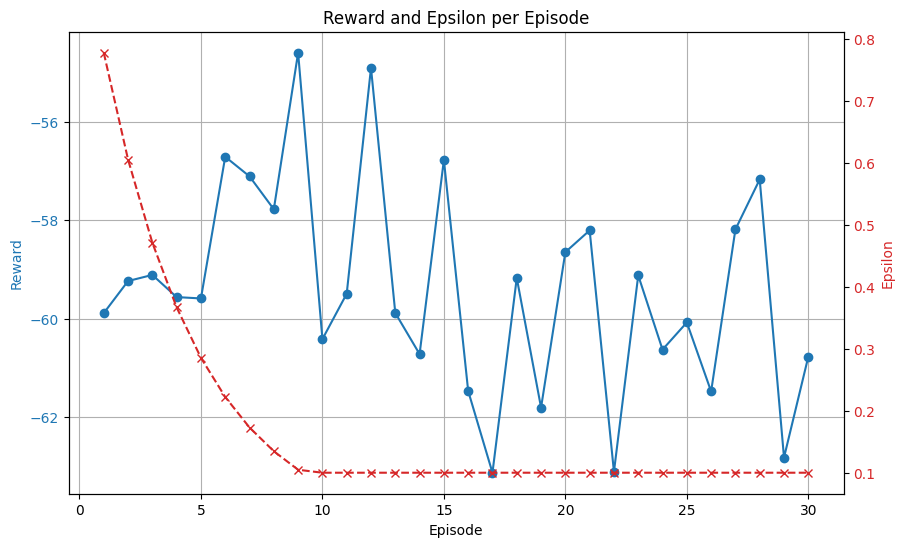

In [1]:
import matplotlib.pyplot as plt

episodes = list(range(1, 31))
rewards = [
    -59.8907, -59.2364, -59.1119, -59.5634, -59.5912, -56.7043, -57.1036, -57.7745, -54.5845, -60.4206,
    -59.4953, -54.8935, -59.8874, -60.7247, -56.7690, -61.4765, -63.1421, -59.1735, -61.8153, -58.6476,
    -58.2044, -63.1236, -59.1217, -60.6336, -60.0802, -61.4864, -58.1846, -57.1662, -62.8329, -60.7786
]
epsilons = [
    0.7783, 0.6058, 0.4715, 0.3670, 0.2856, 0.2223, 0.1730, 0.1347, 0.1048, 0.1000,
    0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
    0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000
]

fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, rewards, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # tạo trục y thứ 2
color = 'tab:red'
ax2.set_ylabel('Epsilon', color=color)
ax2.plot(episodes, epsilons, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Reward and Epsilon per Episode')
plt.show()
